### Feature Selection/Feature Engineering/Modelling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats

%matplotlib inline
pd.pandas.set_option('display.max_columns',None)




sns.set_style('ticks')


### Load the Data

In [2]:
## import training data set
df = pd.read_csv('../datasets/train_cleaned.csv')

In [3]:
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,1stflrsf,2ndflrsf,3ssnporch,alley,bedroomabvgr,bsmtcond,bsmtexposure,bsmtfinsf1,bsmtfinsf2,bsmtfintype1,bsmtfintype2,bsmtfullbath,bsmthalfbath,bsmtqual,bsmtunfsf,electrical,enclosedporch,extercond,exterqual,fence,fireplacequ,fireplaces,fullbath,functional,garagearea,garagecars,garagecond,garagefinish,garagequal,garageyrblt,grlivarea,halfbath,heatingqc,id,kitchenabvgr,kitchenqual,landslope,lotarea,lotfrontage,lotshape,lowqualfinsf,masvnrarea,miscval,openporchsf,overallcond,overallqual,paveddrive,pid,poolarea,poolqc,saleprice,screenporch,totalbsmtsf,totrmsabvgrd,utilities,wooddecksf,yearbuilt,yearremod/add,yrsold,mssubclass_30,mssubclass_40,mssubclass_45,mssubclass_50,mssubclass_60,mssubclass_70,mssubclass_75,mssubclass_80,mssubclass_85,mssubclass_90,mssubclass_120,mssubclass_160,mssubclass_180,mssubclass_190,mszoning_FV,mszoning_I (all),mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,landcontour_HLS,landcontour_Low,landcontour_Lvl,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_Norm,condition2_PosA,condition2_PosN,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,neighborhood_dummies_Blueste,neighborhood_dummies_BrDale,neighborhood_dummies_BrkSide,neighborhood_dummies_ClearCr,neighborhood_dummies_CollgCr,neighborhood_dummies_Crawfor,neighborhood_dummies_Edwards,neighborhood_dummies_Gilbert,neighborhood_dummies_Greens,neighborhood_dummies_IDOTRR,neighborhood_dummies_MeadowV,neighborhood_dummies_Mitchel,neighborhood_dummies_NAmes,neighborhood_dummies_NPkVill,neighborhood_dummies_NWAmes,neighborhood_dummies_NoRidge,neighborhood_dummies_NridgHt,neighborhood_dummies_OldTown,neighborhood_dummies_SWISU,neighborhood_dummies_Sawyer,neighborhood_dummies_SawyerW,neighborhood_dummies_Somerst,neighborhood_dummies_StoneBr,neighborhood_dummies_Timber,neighborhood_dummies_Veenker,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Plywood,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,heating_GasW,heating_Grav,heating_OthW,centralair_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,mosold_2,mosold_3,mosold_4,mosold_5,mosold_6,mosold_7,mosold_8,mosold_9,mosold_10,mosold_11,mosold_12,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_None,alleygrvl,alleypave,miscfeature_Gar2,miscfeature_Othr,miscfeature_Shed,masvnrtype_BrkCmn,masvnrtype_BrkFace,masvnrtype_Stone
0,725,754,0,0,3,3,1,533.0,0.0,6,1,0.0,0.0,3,192.0,0.0,0,3,4,0,0,0,2,0,475.0,2.0,3,RFn,3,1976.0,1479,1,5,109,1,4,0,13517,72.774648,1,0,289.0,0,44,8,6,2,533352170,0,0,130500,0,725.0,6,0,0,1976,2005,2010,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,913,1209,0,0,4,3,1,637.0,0.0,6,1,1.0,0.0,4,276.0,0.0,0,3,4,0,3,1,2,0,559.0,2.0,3,RFn,3,1997.0,2122,1,5,544,1,4,0,11492,43.000000,1,0,132.0,0,74,5,7,2,531379050,0,0,220000,0,913.0,8,0,0,1996,1997,2009,0,0,0,0,1,0,0,0,0,0,0,0,

In [4]:
df.shape

(2048, 207)

### Feature Engineering

It is worth noting that the variables that were correlated with sales price have changed slightly.

**Before Data cleaning:**
- overallqual	0.800207
- grlivarea	0.697038
- garagearea	0.650270
- garagecars	0.648220
- totalbsmtsf	0.628925
- 1stflrsf	0.618486
- yearbuilt	0.571849
- yearremod/add	0.550370
- fullbath	0.537969
- garageyrblt	0.533922

**After Data cleaning:**
- overallqual	0.800975
- exterqual	0.712880
- grlivarea	0.698046
- kitchenqual	0.692190
- garagearea	0.650000
- garagecars	0.648103
- totalbsmtsf	0.631507
- 1stflrsf	0.621181
- bsmtqual	0.617419
- yearbuilt	0.572256


In [58]:
np.abs(df.corr())[['saleprice']].sort_values('saleprice', ascending=False).head()

,saleprice
saleprice,1.000000
overallqual,0.826785
grlivarea,0.726705
exterqual,0.694766
kitchenqual,0.682640


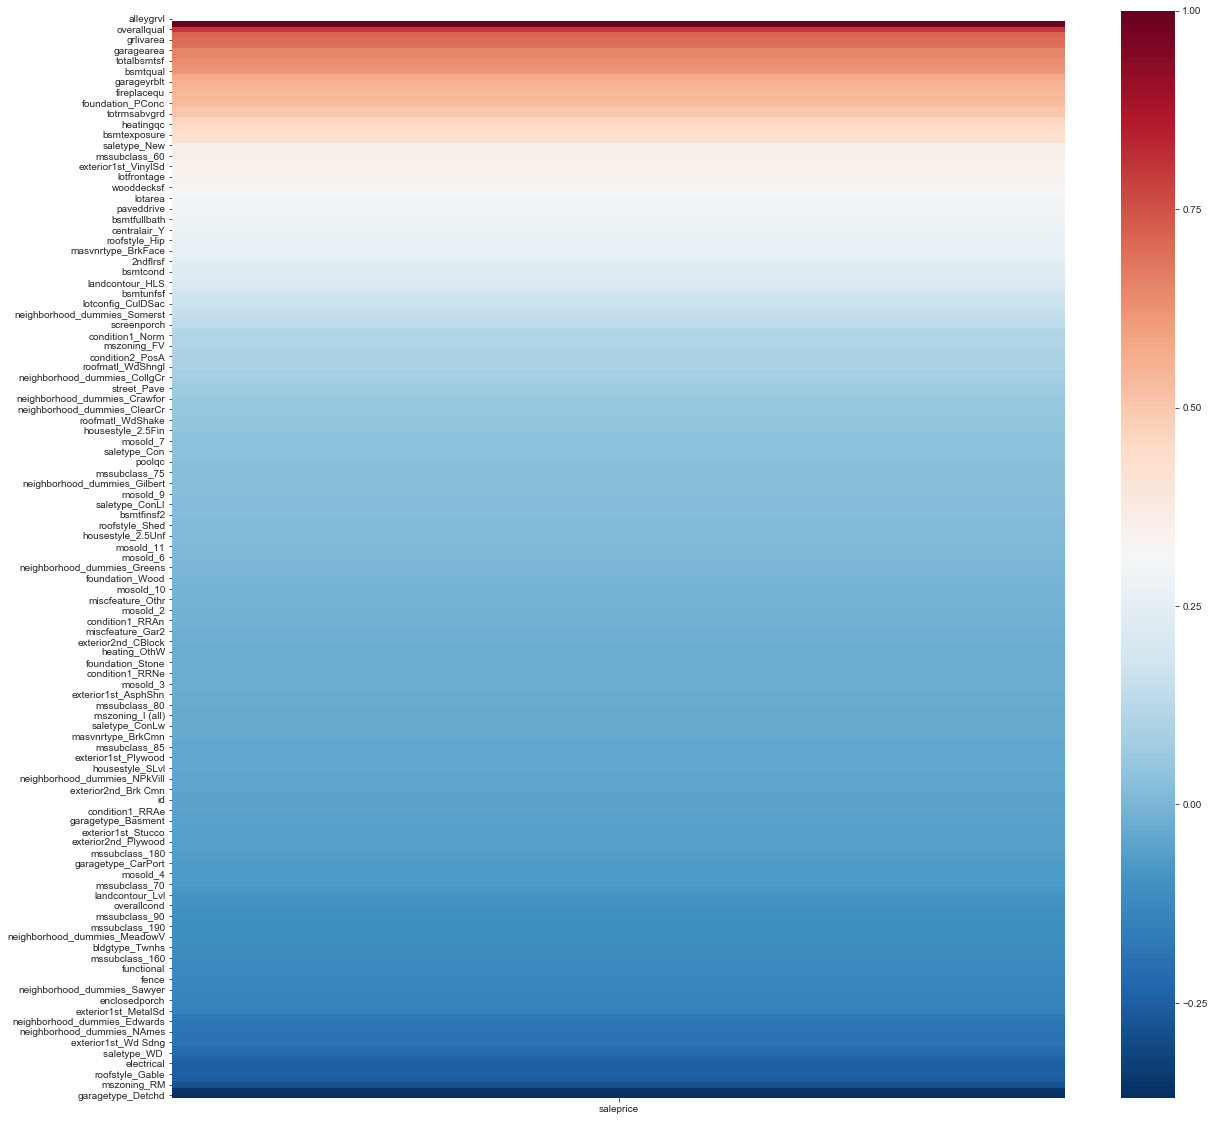

In [6]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr()[['saleprice']].sort_values('saleprice'),
             cmap='RdBu_r', ax=ax);
ax.invert_yaxis()

#### Outliers

Based on the EDA performed during the initial phase of analysis which were visually represented using scatter plot diagrams, there were few obvious outliers that were removed from features such as grlivarea, lotfrontage and lot area.

In [7]:
# dropping obvious outliers seen in scatter plots from EDA
df.drop(df[df['grlivarea'] > 4_500].index, inplace = True)
df.drop(df[df['lotfrontage'] > 300].index, inplace = True)
df.drop(df[df['lotarea'] > 100_000].index, inplace = True)

#### Log transformation

Some of the continuous features were log transformed in order to get a better accuracy from the models.

In [8]:
#### Log transformation
num_features=['lotfrontage', 'lotarea', '1stflrsf', 'grlivarea', 'saleprice']

for feature in num_features:
    df[feature]=np.log(df[feature])


In [9]:
df.shape

(2043, 207)

#### Model Prep: Create features using matrix X and target vector y

In [10]:
features = [col for col in df._get_numeric_data().columns if col != 'saleprice' and col != 'pid']

X = df[features]
y = df['saleprice']

print(X.shape)
print(y.shape)

(2043, 204)
(2043,)


#### Model Prep: Train/Test Split

In [11]:
# we want to have a holdout set to test our model
# train/test split allows us to split our X and y variables into a training set and a holdout set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(X_train.shape)
print(y_train.shape)

(1430, 204)
(1430,)


#### Model Prep: Scaling

Scaled into the same format so that we can see what the strongest predictor is, use across all training data sets.
Trying to find z scores, normalised scores wrt to mean and sd.
As we don't know test srt, we are always going to use mu and sigma.
We use training set statistics to transform test set.
It changes them into a matrix.

In [12]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

#### Hyperparameter Tuning

In [13]:
# Ridge alpha

r_alpha = np.logspace (0,5,200)
# fits multiple alphas
ridgecv = RidgeCV(alphas = r_alpha, cv = 5)
ridgecv = ridgecv.fit(X_train_sc, y_train)

print('optimal ridge alpha: ', ridgecv.alpha_)
print('best ridge R2: ', ridgecv.score(X_train_sc, y_train))

optimal ridge alpha:  32.17641750250737
best ridge R2:  0.9499926261744784


In [14]:
# Lasso alpha
l_alpha = np.arange(0.001,0.15,0.0025)

# fits multiple alphas
lassocv = LassoCV(alphas = l_alpha, cv = 5)
lassocv = lassocv.fit(X_train_sc, y_train)

print('optimal lasso alpha: ', lassocv.alpha_)
print('best lasso R2: ', lassocv.score(X_train_sc, y_train))

optimal lasso alpha:  0.001
best lasso R2:  0.9472442922184922


In [15]:
# Elastic net alpha and lambda
enet_alpha = np.arange(0, 1, 0.005)
enet_ratio = [.01, .1, .2, .3, .5, .7, .9, .95, .99, 1]

# fits multiple alphas and rhos
enetcv = ElasticNetCV(alphas = enet_alpha, l1_ratio = enet_ratio, cv = 5)
enetcv = enetcv.fit(X_train_sc, y_train)

print('optimal enet alpha: ', enetcv.alpha_)
print('optimal enet lambda: ', enetcv.l1_ratio_)
print('best elastic net R2: ', enetcv.score(X_train_sc, y_train))


/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.495203801174426, tolerance: 0.01882020190245558
  tol, rng, random, positive)
/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.709370067594108, tolerance: 0.

/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.32212020133602, tolerance: 0.01882943709989003
  tol, rng, random, positive)
/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.33576436060639, tolerance: 0.01

/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.495203818226031, tolerance: 0.01882020190245558
  tol, rng, random, positive)
/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.709370075329929, tolerance: 0.

optimal enet alpha:  0.005
optimal enet lambda:  0.1
best elastic net R2:  0.9495036187395606


/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/Users/Shandeep/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.335764372177323, tolerance: 0.018781023942810733
  tol, rng, random, positive)


### Cross Validation

Using cross val score and fine tuning the model using the hyperparameters, **Lasso Regression** performed best after comparing R^2 models among other models such as the Standard Linear Regression model, Ridge Regression and the Elastic Net model. Linear regression produced the worst result, which further supports the importance of regularised models. This could have been due to several factors; the number of features that were taken into consideration, the high degree of generalisation and so on.

#### Linear Regression

In [16]:
lr = LinearRegression()

In [17]:
# Cross Validation
nfolds = 5 
def crossval(model, x, y):
    kf = KFold(nfolds, shuffle = True, random_state = 42)
    rmse = np.sqrt(-cross_val_score(model, x, y, cv = kf, scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(model, x, y, cv = kf)
    return 'mean CV R2:', r2.mean(), \
            'mean CV RMSE:', rmse.mean()
            

In [18]:
print('Linear Regression: \n', crossval(lr, X_train_sc, y_train))

Linear Regression: 
 ('mean CV R2:', -2.6603255938332492e+20, 'mean CV RMSE:', 2732974919.6020064)


#### Ridge Regression

In [19]:
ridge = Ridge(alpha = ridgecv.alpha_)

In [20]:
print('RIDGE: \n', crossval(ridge, X_train_sc, y_train))

RIDGE: 
 ('mean CV R2:', 0.9186596754777184, 'mean CV RMSE:', 0.11447777636067813)


#### Lasso Regression

In [21]:
lasso = Lasso(alpha = lassocv.alpha_)

In [22]:
print('LASSO: \n', crossval(lasso, X_train_sc, y_train))

LASSO: 
 ('mean CV R2:', 0.9205551576069168, 'mean CV RMSE:', 0.1130480595684138)


#### Elastic Net Regression

In [23]:
enet = ElasticNet(alpha = enetcv.alpha_, l1_ratio = enetcv.l1_ratio_)

In [24]:
print('ELASTIC NET: \n', crossval(enet, X_train_sc, y_train))

ELASTIC NET: 
 ('mean CV R2:', 0.9199422042955441, 'mean CV RMSE:', 0.1135223514425215)


### Model Fitting and Evaluation

As Lasso regression produced best result on the training data set, this model will be used on the test data set. Initial analysis suggests that my training set could be facing problems with overfitting. The R2 of the model has dropped when applying the model on the test set. This would imply that the model doesn't generalise too well on unseen data as its variance is a little too high. The goal now is to attempt to fine tune the model such that the variance could be decreased and the bias increased ever so slightly.

In [25]:
def rmse(ytest, ypred):
    return np.sqrt(mean_squared_error(y_test, ypred))

In [26]:
# fitting model to train data
lr = lr.fit(X_train_sc, y_train)

# predicting model on test data
ypred = lr.predict(X_test_sc)

# model performance
print('Linear Regression model test R2: ', lr.score(X_test_sc, y_test))
print('Linear Regression model test RMSE: ', rmse(y_test, ypred))

Linear Regression model test R2:  -5498955.486232451
Linear Regression model test RMSE:  1001.7236842572172


In [27]:
# fitting model to train data
ridge = ridge.fit(X_train_sc, y_train)

# predicting model on test data
ypred = ridge.predict(X_test_sc)

# model performance
print('Ridge Regression model test R2: ', ridge.score(X_test_sc, y_test))
print('Ridge Regression model test RMSE: ', rmse(y_test, ypred))

Ridge Regression model test R2:  0.8970132249437166
Ridge Regression model test RMSE:  0.13708771259949407


In [28]:
# fitting model to train data
lasso = lasso.fit(X_train_sc, y_train)

# predicting model on test data
ypred = lasso.predict(X_test_sc)

# model performance
print('Lasso Regression model test R2: ', lasso.score(X_test_sc, y_test))
print('Lasso Regression model test RMSE: ', rmse(y_test, ypred))

Lasso Regression model test R2:  0.898556673388939
Lasso Regression model test RMSE:  0.13605657742337182


In [29]:
# fitting model to train data
enet = enet.fit(X_train_sc, y_train)

# predicting model on test data
ypred = enet.predict(X_test_sc)

# model performance
print('Enet Regression model test R2: ', enet.score(X_test_sc, y_test))
print('Enet Regression model test RMSE: ', rmse(y_test, ypred))

Enet Regression model test R2:  0.898050014247435
Enet Regression model test RMSE:  0.13639592182439852


#### Re model - Log transform only sales price, not dealing with outliers

In this model, the opposite happened. The model proved to be a good generalisation on the test set but suffers from very high bias. The difference is R2 is huge as compared to the earlier model and that, in turn, has led me to pick the first model to see how it performs on Kaggle test data set.

In [30]:
df2 = pd.read_csv('../datasets/train_cleaned.csv')

In [31]:
df2.drop(columns='Unnamed: 0', inplace=True)
df2.head()

,1stflrsf,2ndflrsf,3ssnporch,alley,bedroomabvgr,bsmtcond,bsmtexposure,bsmtfinsf1,bsmtfinsf2,bsmtfintype1,bsmtfintype2,bsmtfullbath,bsmthalfbath,bsmtqual,bsmtunfsf,electrical,enclosedporch,extercond,exterqual,fence,fireplacequ,fireplaces,fullbath,functional,garagearea,garagecars,garagecond,garagefinish,garagequal,garageyrblt,grlivarea,halfbath,heatingqc,id,kitchenabvgr,kitchenqual,landslope,lotarea,lotfrontage,lotshape,lowqualfinsf,masvnrarea,miscval,openporchsf,overallcond,overallqual,paveddrive,pid,poolarea,poolqc,saleprice,screenporch,totalbsmtsf,totrmsabvgrd,utilities,wooddecksf,yearbuilt,yearremod/add,yrsold,mssubclass_30,mssubclass_40,mssubclass_45,mssubclass_50,mssubclass_60,mssubclass_70,mssubclass_75,mssubclass_80,mssubclass_85,mssubclass_90,mssubclass_120,mssubclass_160,mssubclass_180,mssubclass_190,mszoning_FV,mszoning_I (all),mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,landcontour_HLS,landcontour_Low,landcontour_Lvl,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_Norm,condition2_PosA,condition2_PosN,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,neighborhood_dummies_Blueste,neighborhood_dummies_BrDale,neighborhood_dummies_BrkSide,neighborhood_dummies_ClearCr,neighborhood_dummies_CollgCr,neighborhood_dummies_Crawfor,neighborhood_dummies_Edwards,neighborhood_dummies_Gilbert,neighborhood_dummies_Greens,neighborhood_dummies_IDOTRR,neighborhood_dummies_MeadowV,neighborhood_dummies_Mitchel,neighborhood_dummies_NAmes,neighborhood_dummies_NPkVill,neighborhood_dummies_NWAmes,neighborhood_dummies_NoRidge,neighborhood_dummies_NridgHt,neighborhood_dummies_OldTown,neighborhood_dummies_SWISU,neighborhood_dummies_Sawyer,neighborhood_dummies_SawyerW,neighborhood_dummies_Somerst,neighborhood_dummies_StoneBr,neighborhood_dummies_Timber,neighborhood_dummies_Veenker,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Plywood,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,heating_GasW,heating_Grav,heating_OthW,centralair_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,mosold_2,mosold_3,mosold_4,mosold_5,mosold_6,mosold_7,mosold_8,mosold_9,mosold_10,mosold_11,mosold_12,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_None,alleygrvl,alleypave,miscfeature_Gar2,miscfeature_Othr,miscfeature_Shed,masvnrtype_BrkCmn,masvnrtype_BrkFace,masvnrtype_Stone
0,725,754,0,0,3,3,1,533.0,0.0,6,1,0.0,0.0,3,192.0,0.0,0,3,4,0,0,0,2,0,475.0,2.0,3,RFn,3,1976.0,1479,1,5,109,1,4,0,13517,72.774648,1,0,289.0,0,44,8,6,2,533352170,0,0,130500,0,725.0,6,0,0,1976,2005,2010,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,913,1209,0,0,4,3,1,637.0,0.0,6,1,1.0,0.0,4,276.0,0.0,0,3,4,0,3,1,2,0,559.0,2.0,3,RFn,3,1997.0,2122,1,5,544,1,4,0,11492,43.000000,1,0,132.0,0,74,5,7,2,531379050,0,0,220000,0,913.0,8,0,0,1996,1997,2009,0,0,0,0,1,0,0,0,0,0,0,0,

In [32]:
features = [col for col in df2._get_numeric_data().columns if col != 'saleprice' and col != 'pid']

X = df2[features]
y = df2['saleprice']

print(X.shape)
print(y.shape)

(2048, 204)
(2048,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=19)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [34]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [35]:
# Cross Validation
nfolds = 5 
def crossval(model, x, y):
    kf = KFold(nfolds, shuffle = True, random_state = 42)
    rmse = np.sqrt(-cross_val_score(model, x, y, cv = kf, scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(model, x, y, cv = kf)
    return 'mean CV R2:', r2.mean(), \
            'mean CV RMSE:', rmse.mean()
            

In [36]:
lasso = Lasso(alpha = lassocv.alpha_)

In [37]:
print('LASSO: \n', crossval(lasso, X_train_sc, y_train_log))

LASSO: 
 ('mean CV R2:', 0.8498678075801649, 'mean CV RMSE:', 0.15405346551958138)


In [38]:
# fitting model to train data
lasso = lasso.fit(X_train_sc, y_train_log)

# predicting model on test data
ypred = lasso.predict(X_test_sc)

# model performance
print('Lasso Regression model test R2: ', lasso.score(X_test_sc, y_test_log))
print('Lasso Regression model test RMSE: ', rmse(y_test_log, ypred))

Lasso Regression model test R2:  0.9103418986759808
Lasso Regression model test RMSE:  199016.79398690123


Once testing performance of the model on the test bloc, we can use the same parameters and re-fit (or re-train) our the on the entire training set (train bloc and test bloc) to give it as much learning data as possible, then use that model to generate predictions for the Kaggle test set. R

In [39]:
df.shape

(2043, 207)

In [40]:
features = [col for col in df._get_numeric_data().columns if col != 'saleprice' and col != 'pid']

X = df[features]
y = df['saleprice']

print(X.shape)
print(y.shape)

(2043, 204)
(2043,)


In [41]:
# we want to have a holdout set to test our model
# train/test split allows us to split our X and y variables into a training set and a holdout set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(y_train.shape)

(1634, 204)
(1634,)


In [42]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [43]:
# Lasso alpha
l_alpha = np.arange(0.001,0.15,0.0025)

# fits multiple alphas
lassocv = LassoCV(alphas = l_alpha, cv = 5)
lassocv = lassocv.fit(X_train_sc, y_train)

print('optimal lasso alpha: ', lassocv.alpha_)
print('best lasso R2: ', lassocv.score(X_train_sc, y_train))

optimal lasso alpha:  0.001
best lasso R2:  0.9441943152786746


In [44]:
lasso = Lasso(alpha = lassocv.alpha_)
print('LASSO: \n', crossval(lasso, X_train_sc, y_train))

LASSO: 
 ('mean CV R2:', 0.9223753954184509, 'mean CV RMSE:', 0.11261153937431576)


In [45]:
# fitting model to train data
lasso = lasso.fit(X_train_sc, y_train)

# predicting model on test data
ypred = lasso.predict(X_test_sc)

# model performance
print('Lasso Regression model test R2: ', lasso.score(X_test_sc, y_test))
print('Lasso Regression model test RMSE: ', rmse(y_test, ypred))

Lasso Regression model test R2:  0.8937499697619783
Lasso Regression model test RMSE:  0.14041354113974142


### Conclusion

The predictions are fairly accurate up to a point. Generally speaking, it is harder to predict sales price after the values exceed 350 000 dollars. This can be further underlined through a box plot which visually represents the distribution of sales price. It is evident that the outliers are probably the reason why it is extremely difficult to predict sales price with such accuracy. Model explains 89% of variation on unseen data.

The model may however have some problems as it was based on data on houses sold between 2006 - 2010 and it represents a very small time frame and only a the city of Ames. This dataset is limited in scope both in terms of the time frame captured, as well as location. House prices could be a little challenging to predict as it is also affected by a wide variety of factors such as how the economy is performing, expectations of individuals of what they deem the house price should be, or other possible variables that were excluded in the data set. Thus, this model serves with limited scope and it is, without a doubt, still useful to some degree.

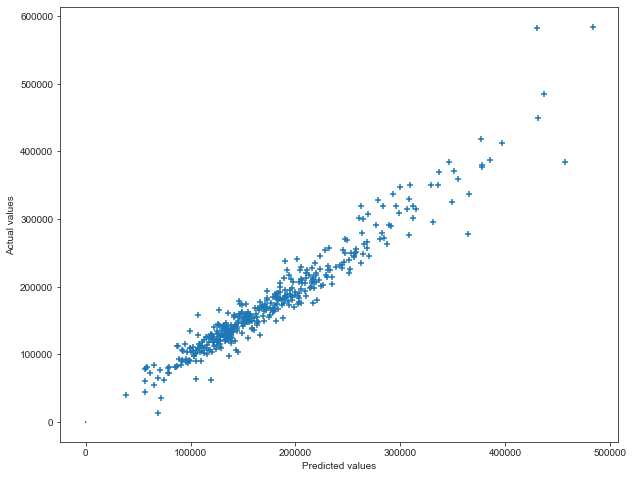

In [46]:
#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter(np.exp(ypred), np.exp(y_test),marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')

#Plots x=y line
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'k');

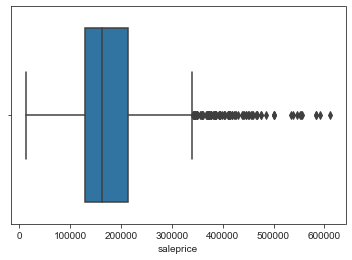

In [47]:
sns.boxplot(np.exp(df['saleprice']))

### Uploading to Kaggle

In [48]:
testset = pd.read_csv('../datasets/test_cleaned.csv')

In [49]:
testset.drop(columns='Unnamed: 0', inplace=True)
testset.head()

,id,pid,lotfrontage,lotarea,alley,lotshape,utilities,landslope,overallqual,overallcond,yearbuilt,yearremod/add,masvnrarea,exterqual,extercond,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heatingqc,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscval,yrsold,mssubclass_30,mssubclass_40,mssubclass_45,mssubclass_50,mssubclass_60,mssubclass_70,mssubclass_75,mssubclass_80,mssubclass_85,mssubclass_90,mssubclass_120,mssubclass_160,mssubclass_180,mssubclass_190,mszoning_FV,mszoning_I (all),mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,landcontour_HLS,landcontour_Low,landcontour_Lvl,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_Norm,condition2_PosA,condition2_PosN,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,neighborhood_dummies_Blueste,neighborhood_dummies_BrDale,neighborhood_dummies_BrkSide,neighborhood_dummies_ClearCr,neighborhood_dummies_CollgCr,neighborhood_dummies_Crawfor,neighborhood_dummies_Edwards,neighborhood_dummies_Gilbert,neighborhood_dummies_Greens,neighborhood_dummies_IDOTRR,neighborhood_dummies_MeadowV,neighborhood_dummies_Mitchel,neighborhood_dummies_NAmes,neighborhood_dummies_NPkVill,neighborhood_dummies_NWAmes,neighborhood_dummies_NoRidge,neighborhood_dummies_NridgHt,neighborhood_dummies_OldTown,neighborhood_dummies_SWISU,neighborhood_dummies_Sawyer,neighborhood_dummies_SawyerW,neighborhood_dummies_Somerst,neighborhood_dummies_StoneBr,neighborhood_dummies_Timber,neighborhood_dummies_Veenker,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_Metal,roofmatl_Roll,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_PreCast,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Other,exterior2nd_Plywood,exterior2nd_PreCast,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,heating_GasA,heating_GasW,heating_Grav,centralair_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_VWD,saletype_WD,mosold_2,mosold_3,mosold_4,mosold_5,mosold_6,mosold_7,mosold_8,mosold_9,mosold_10,mosold_11,mosold_12,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_None,alleygrvl,alleypave,miscfeature_Gar2,miscfeature_Othr,miscfeature_Shed,masvnrtype_BrkCmn,masvnrtype_BrkFace,masvnrtype_CBlock,masvnrtype_Stone,Electrical
0,2658,902301120,69.000000,9142,1,0,0,0,6,8,1910,1950,0.0,3,2,2,3,1,1,0,1,0,1020,1020,4,3.0,908,1020,0,1928,0,0,2,0,4,2,2,9,0,0,0,1910.0,Unf,1,440,1,1,2,0,60,112,0,0,0,0,0,0,2006,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.0
1,2718,905108090,72.774648,9662,0,1,0,0,5,4,1977,1977,0.0,3,3,4,3,1,1,0,1,0,1967,1967,3,0.0,1967,0,0,1967,0,0,2

In [50]:
testset.drop(testset[testset['grlivarea'] > 4_500].index, inplace = True)
testset.drop(testset[testset['lotfrontage'] > 300].index, inplace = True)
testset.drop(testset[testset['lotarea'] > 100_000].index, inplace = True)

num_features=['lotfrontage', 'lotarea', '1stflrsf', 'grlivarea']

for feature in num_features:
    testset[feature]=np.log(testset[feature])

In [51]:
ypred.shape

(409,)

In [52]:
submission = pd.DataFrame(np.exp(ypred), columns =['saleprice'])
submission['id'] = testset['id']
submission = submission[['id', 'saleprice']]

In [53]:
submission

,id,saleprice
0,2658.0,308505.790914
1,2718.0,312188.147114
2,2414.0,230557.011598
3,1989.0,178382.120554
4,625.0,126465.079250
5,333.0,255656.722960
6,1327.0,296328.854939
7,858.0,431101.955360
8,95.0,125939.377746
9,1568.0,149679.790827


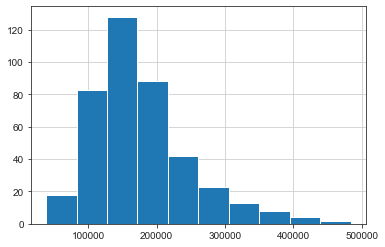

In [55]:
submission['saleprice'].hist()

In [ ]:
submission.to_csv('../datasets/kaggle_submission.csv',index=False)